In [ ]:
import os
import random

import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, det_curve,ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import keras
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeNormal


import cv2 as cv

import matplotlib.pyplot as plt
import seaborn as sns


# Paths to your data
base_dir = '/kaggle/input/leukemia-classification'  # Replace with your directory (whatever current directory this notebook is in)
train_dir = os.path.join(base_dir, 'C-NMC_Leukemia/training_data/') # make sure this data is in the base_dir
test_csv = os.path.join(base_dir, 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')
test_imgs = os.path.join(base_dir, 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/')




# Function to define file paths and labels
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)

        for fold_ in filelist:
            foldpath_ = os.path.join(foldpath, fold_)
            filelist_ = os.listdir(foldpath_)

            for file_ in filelist_:
                fpath = os.path.join(foldpath_, file_)
                filepaths.append(fpath)
                labels.append(fold_)

    return filepaths, labels


def get_test_df(base_dir):
    test_data = pd.read_csv(test_csv)

    X_test = []

    for image_name in test_data.new_names:
        # Loading images
        img = test_imgs + image_name

        X_test.append(img)

    # Storing target values as well
    y_test = test_data.labels.values
    test_df = pd.DataFrame({'filepaths':X_test,'labels':y_test})
    test_df['labels'] = test_df['labels'].apply(lambda x: 'all' if x==1 else 'hem')
    return test_df




# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


# Function that create dataframe for train, validation, and test data
def create_df(data_dir):

    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)

    train_df, valid_df = train_test_split(df, train_size=0.8, random_state=rs)

    return train_df, valid_df

In [ ]:
def define_paths(dir):

    filepaths, labels  = [], []

    for root, dirs, files in os.walk(dir):
        for file in files:
            fpath = os.path.join(root, file)
            filepaths.append(fpath)
            labels.append(os.path.basename(root))

    return filepaths, labels


def create_df(data_dir):

    # Collect filepaths and labels
    filepaths, labels = define_paths(data_dir)

    # Create a Pandas DataFrame
    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

    # Split the DataFrame into train, validation, and test sets
    train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])


    return train_df, valid_df, test_df

In [ ]:
def create_model_data(train_df, valid_df, test_df, batch_size):
    '''
    Prepares image data generators for training, validation, and test datasets from the given dataframes.
    '''

    img_size = (224, 224)
    color = 'rgb'

    # Calculate optimized batch size for the test data
    ts_length = len(test_df)
    test_batch_size = max([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80])

    # Define image data generators
    gen_params = {'preprocessing_function': lambda img: img, 'target_size': img_size,
                  'color_mode': color, 'class_mode': 'categorical'}

    tr_gen = ImageDataGenerator(horizontal_flip=True)
    ts_gen = ImageDataGenerator()

    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', shuffle=True, batch_size=batch_size, **gen_params)
    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', shuffle=True, batch_size=batch_size, **gen_params)
    test_gen  = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', shuffle=False, batch_size=test_batch_size, **gen_params)

    return train_gen, valid_gen, test_gen

In [ ]:
def show_history_plot(history):

    training_accuracy = history['accuracy']
    epochs = range(1, len(training_accuracy) + 1)

    # Creating subplots for accuracy and loss
    plt.figure(figsize=(15, 5))

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    plt.plot(epochs, history['accuracy'], 'b', label='Training accuracy', marker='o')
    plt.plot(epochs, history['val_accuracy'], 'c', label='Validation accuracy', marker='o')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.plot(epochs, history['loss'], 'b', label='Training loss', marker='o')
    plt.plot(epochs, history['val_loss'], 'c', label='Validation loss', marker='o')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Improve layout and displaying the plot
    plt.tight_layout()
    plt.show()

In [ ]:
def show_conf_matrix(model):
    test_gen.reset()  # Reset the generator to be sure it's at the start of the dataset
    y_pred = model.predict(test_gen, steps=test_gen.n // test_gen.batch_size+1, verbose=0)

    label_dict = test_gen.class_indices
    classes = list(label_dict.keys())

    # Convert predictions to labels
    pred_labels = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes

    # Generate the confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_true, pred_labels)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])

    # Plot the confusion matrix
    cmap = plt.cm.Blues
    cm_display.plot(cmap=cmap, colorbar=False)

    plt.title('Confusion Matrix', fontsize=16)
    plt.figure(figsize=(7, 7))
    plt.show()

In [ ]:
!pip install -q kaggle


In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json here


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d andrewmvd/leukemia-classification -p /content/leukemia_data


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/leukemia-classification
License(s): other
100% 866M/867M [00:29<00:00, 30.2MB/s]
100% 867M/867M [00:29<00:00, 30.4MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile("/content/leukemia_data/leukemia-classification.zip", "r") as zip_ref:
    zip_ref.extractall("/content/leukemia_data")


In [ ]:
base_dir = '/content/leukemia_data/C-NMC_Leukemia'
train_dir = os.path.join(base_dir, 'training_data')
test_csv = os.path.join(base_dir, 'validation_data/C-NMC_test_prelim_phase_data_labels.csv')
test_imgs = os.path.join(base_dir, 'validation_data/C-NMC_test_prelim_phase_data')


In [ ]:
train_df, valid_df, test_df = create_df(train_dir)
print(train_df.head())
print(valid_df.head())
print(test_df.head())


                                               filepaths labels
5035   /content/leukemia_data/C-NMC_Leukemia/training...    all
10011  /content/leukemia_data/C-NMC_Leukemia/training...    all
4404   /content/leukemia_data/C-NMC_Leukemia/training...    hem
8633   /content/leukemia_data/C-NMC_Leukemia/training...    all
6891   /content/leukemia_data/C-NMC_Leukemia/training...    all
                                               filepaths labels
7549   /content/leukemia_data/C-NMC_Leukemia/training...    hem
3586   /content/leukemia_data/C-NMC_Leukemia/training...    hem
10135  /content/leukemia_data/C-NMC_Leukemia/training...    all
6422   /content/leukemia_data/C-NMC_Leukemia/training...    all
5488   /content/leukemia_data/C-NMC_Leukemia/training...    all
                                              filepaths labels
5722  /content/leukemia_data/C-NMC_Leukemia/training...    all
3085  /content/leukemia_data/C-NMC_Leukemia/training...    all
6737  /content/leukemia_data/C-NMC_Leukemia

In [ ]:
# Create the dataframes
train_df, valid_df, test_df = create_df(train_dir)

# Print the first few rows of each DataFrame
print("Train DataFrame Sample:")
print(train_df.head())
print("\nValidation DataFrame Sample:")
print(valid_df.head())
print("\nTest DataFrame Sample:")
print(test_df.head())

# Get the counts of each label in train, validation, and test sets
train_label_counts = train_df['labels'].value_counts()
valid_label_counts = valid_df['labels'].value_counts()
test_label_counts = test_df['labels'].value_counts()

# Print the counts
print("\nLabel counts in Train DataFrame:")
print(train_label_counts)

print("\nLabel counts in Validation DataFrame:")
print(valid_label_counts)

print("\nLabel counts in Test DataFrame:")
print(test_label_counts)


Train DataFrame Sample:
                                               filepaths labels
5035   /content/leukemia_data/C-NMC_Leukemia/training...    all
10011  /content/leukemia_data/C-NMC_Leukemia/training...    all
4404   /content/leukemia_data/C-NMC_Leukemia/training...    hem
8633   /content/leukemia_data/C-NMC_Leukemia/training...    all
6891   /content/leukemia_data/C-NMC_Leukemia/training...    all

Validation DataFrame Sample:
                                               filepaths labels
7549   /content/leukemia_data/C-NMC_Leukemia/training...    hem
3586   /content/leukemia_data/C-NMC_Leukemia/training...    hem
10135  /content/leukemia_data/C-NMC_Leukemia/training...    all
6422   /content/leukemia_data/C-NMC_Leukemia/training...    all
5488   /content/leukemia_data/C-NMC_Leukemia/training...    all

Test DataFrame Sample:
                                              filepaths labels
5722  /content/leukemia_data/C-NMC_Leukemia/training...    all
3085  /content/leukemia_data

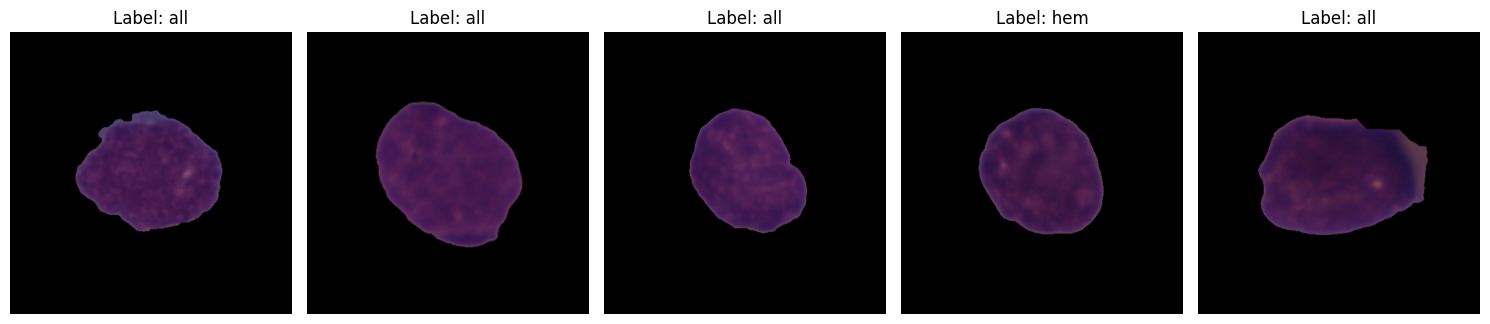

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random

# Function to plot samples from the dataset
def plot_samples(dataframe, num_samples=5):
    plt.figure(figsize=(15, 10))

    # Randomly select some samples from the dataframe
    samples = dataframe.sample(num_samples).reset_index(drop=True)

    for i in range(num_samples):
        # Load the image from the file path
        img_path = samples['filepaths'][i]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get the label of the image
        label = samples['labels'][i]

        # Plotting each image
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot samples from the training dataset
plot_samples(train_df, num_samples=5)


In [ ]:
# Print the number of images in each set
print("Number of images in each dataset:")
print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(valid_df)} images")
print(f"Test set: {len(test_df)} images")


Number of images in each dataset:
Training set: 7462 images
Validation set: 1599 images
Test set: 1600 images


In [ ]:
#DATA PREPROCESSING
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size and batch size
img_size = (224, 224)
batch_size = 32

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,              # Normalizes pixel values between 0 and 1
    rotation_range=20,             # Randomly rotates images up to 20 degrees
    width_shift_range=0.2,         # Randomly shifts images horizontally
    height_shift_range=0.2,        # Randomly shifts images vertically
    shear_range=0.15,              # Applies random shearing
    zoom_range=0.2,                # Randomly zooms into images
    horizontal_flip=True,          # Randomly flips images horizontally
    fill_mode='nearest'            # Fills empty pixels after transforms
)

# Only normalization for validation and test (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Creating data generators
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

valid_gen = test_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 7462 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.


Found 7462 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


234/234 ━━━━━━━━━━━━━━━━━━━━ 47s 142ms/step - accuracy: 0.7396 - loss: 7.9791 - val_accuracy: 0.8005 - val_loss: 0.4252
Epoch 2/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - accuracy: 0.7886 - loss: 0.4897 - val_accuracy: 0.8305 - val_loss: 0.4152
Epoch 3/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - accuracy: 0.7955 - loss: 0.4527 - val_accuracy: 0.8330 - val_loss: 0.4000
Epoch 4/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.8086 - loss: 0.4509 - val_accuracy: 0.8243 - val_loss: 0.4314
Epoch 5/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.8066 - loss: 0.4599 - val_accuracy: 0.8330 - val_loss: 0.4023
Epoch 6/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.8155 - loss: 0.4376 - val_accuracy: 0.8143 - val_loss: 0.4314
Epoch 7/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.8052 - loss: 0.4585 - val_accuracy: 0.8349 - val_loss: 0.3818
Epoch 8/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.8126 - loss: 0.4388

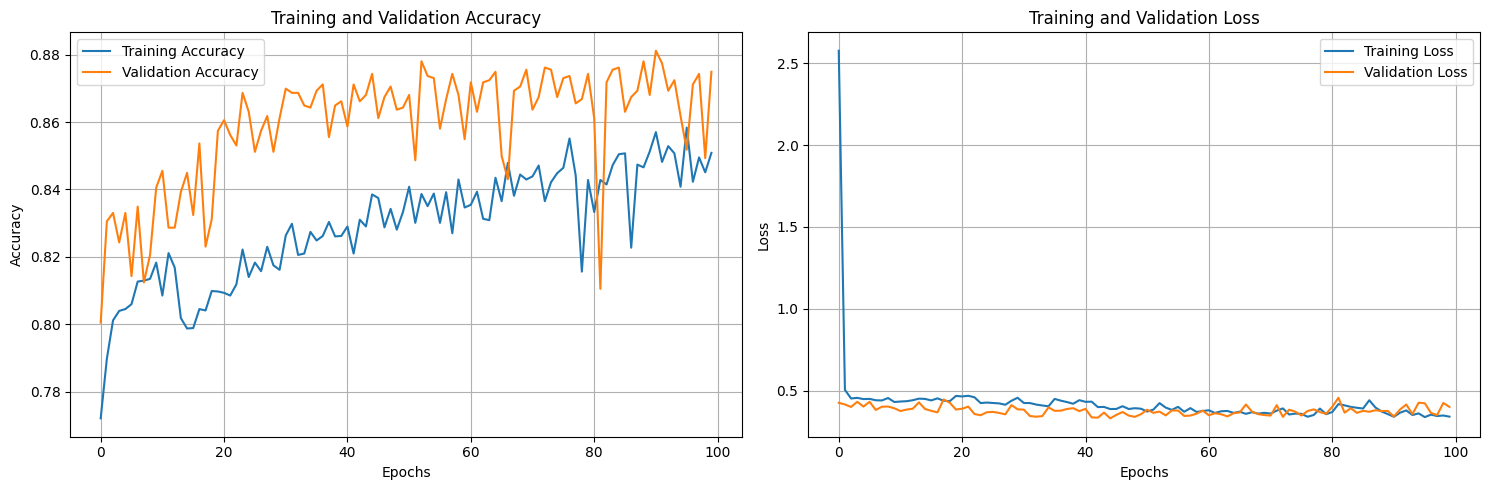

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step
              precision    recall  f1-score   support

         all       0.68      0.75      0.72      1091
         hem       0.33      0.26      0.29       509

    accuracy                           0.59      1600
   macro avg       0.51      0.50      0.50      1600
weighted avg       0.57      0.59      0.58      1600



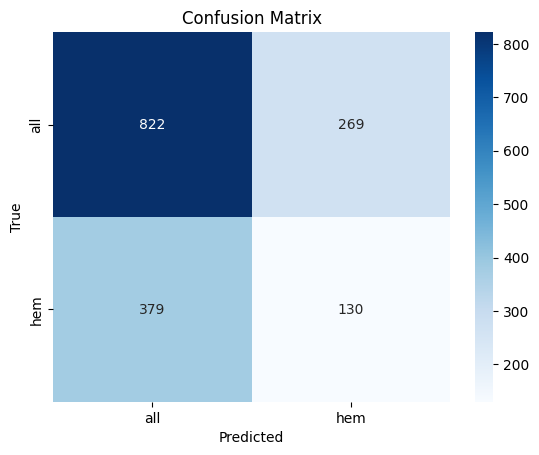

In [ ]:
# RESNET WITH 100 EPOCHS
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Paths to your data
base_dir = '/content/leukemia_data'  # Update this path
train_dir = os.path.join(base_dir, 'C-NMC_Leukemia/training_data/')
test_csv = os.path.join(base_dir, 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')
test_imgs = os.path.join(base_dir, 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/')

# Define paths and labels
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for fold_ in filelist:
            foldpath_ = os.path.join(foldpath, fold_)
            filelist_ = os.listdir(foldpath_)
            for file_ in filelist_:
                fpath = os.path.join(foldpath_, file_)
                filepaths.append(fpath)
                labels.append(fold_)
    return filepaths, labels

# Create DataFrame
def create_df(data_dir):
    filepaths, labels = define_paths(data_dir)
    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
    return train_df, valid_df, test_df

# Create data generators
def create_data_generators(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)

    train_gen = ImageDataGenerator(horizontal_flip=True).flow_from_dataframe(train_df, x_col='filepaths',
                                                                           y_col='labels', target_size=img_size,
                                                                           class_mode='categorical', batch_size=batch_size)

    valid_gen = ImageDataGenerator().flow_from_dataframe(valid_df, x_col='filepaths',
                                                          y_col='labels', target_size=img_size,
                                                          class_mode='categorical', batch_size=batch_size)

    test_gen = ImageDataGenerator().flow_from_dataframe(test_df, x_col='filepaths',
                                                         y_col='labels', target_size=img_size,
                                                         class_mode='categorical', batch_size=batch_size)

    return train_gen, valid_gen, test_gen

# Define and compile the model
def create_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the base model layers

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')  # Adjust the output layer based on your classes
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the model
def train_model(model, train_gen, valid_gen, epochs):
    history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs)
    return history

# Plotting functions
def plot_metrics(history):
    # Plotting training and validation accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Evaluate model and plot confusion matrix
def evaluate_model(model, test_gen):
    test_gen.reset()
    y_pred = model.predict(test_gen)
    pred_labels = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes

    # Print classification report
    print(classification_report(y_true, pred_labels, target_names=test_gen.class_indices.keys()))

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Main execution
data_dir = '/content/leukemia_data/C-NMC_Leukemia/training_data'  # Update this path
train_df, valid_df, test_df = create_df(data_dir)
batch_size = 32  # Adjust based on your GPU memory
train_gen, valid_gen, test_gen = create_data_generators(train_df, valid_df, test_df, batch_size)

# Create and train the model
model = create_model()
epochs = 100  # Set the desired number of epochs here
history = train_model(model, train_gen, valid_gen, epochs)

# Plot metrics and evaluate model
plot_metrics(history)
evaluate_model(model, test_gen)


Found 7462 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


234/234 ━━━━━━━━━━━━━━━━━━━━ 77s 217ms/step - accuracy: 0.7267 - loss: 0.8924 - val_accuracy: 0.8055 - val_loss: 0.4399
Epoch 2/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.7951 - loss: 0.4625 - val_accuracy: 0.8149 - val_loss: 0.4261
Epoch 3/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.8118 - loss: 0.4392 - val_accuracy: 0.8074 - val_loss: 0.4302
Epoch 4/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.8081 - loss: 0.4388 - val_accuracy: 0.8130 - val_loss: 0.4483
Epoch 5/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.8140 - loss: 0.4347 - val_accuracy: 0.8161 - val_loss: 0.4160
Epoch 6/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.8255 - loss: 0.4187 - val_accuracy: 0.8111 - val_loss: 0.4247
Epoch 7/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.8161 - loss: 0.4300 - val_accuracy: 0.8168 - val_loss: 0.4152
Epoch 8/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.8185 - loss: 0.4206 - val

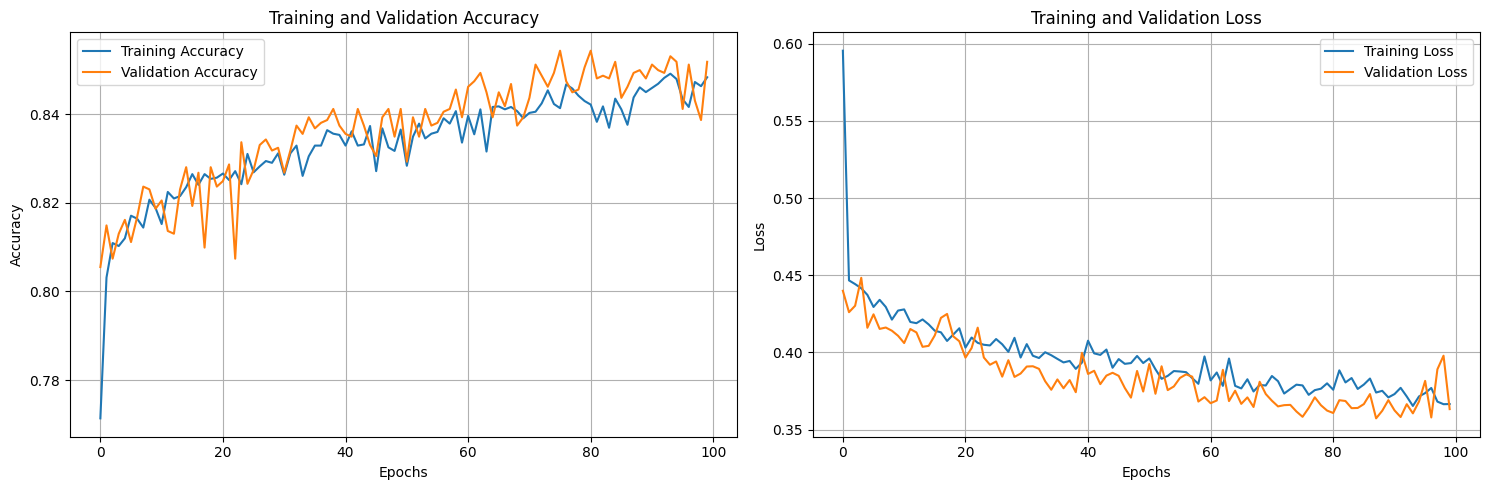

50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step
              precision    recall  f1-score   support

         all       0.68      0.72      0.70      1091
         hem       0.32      0.28      0.30       509

    accuracy                           0.58      1600
   macro avg       0.50      0.50      0.50      1600
weighted avg       0.57      0.58      0.57      1600



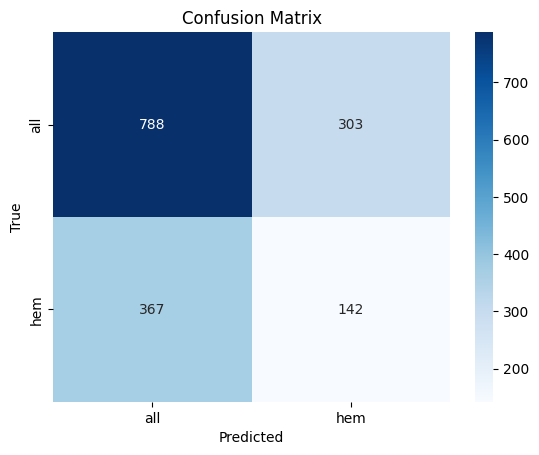

In [ ]:
#DENSE NET 121-remove
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models

# Paths to your data
base_dir = '/content/leukemia_data'  # Update this path as necessary
train_dir = os.path.join(base_dir, 'C-NMC_Leukemia/training_data/')
test_csv = os.path.join(base_dir, 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')
test_imgs = os.path.join(base_dir, 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/')

# Define paths and labels
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for fold_ in filelist:
            foldpath_ = os.path.join(foldpath, fold_)
            filelist_ = os.listdir(foldpath_)
            for file_ in filelist_:
                fpath = os.path.join(foldpath_, file_)
                filepaths.append(fpath)
                labels.append(fold_)
    return filepaths, labels

# Create DataFrame
def create_df(data_dir):
    filepaths, labels = define_paths(data_dir)
    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
    return train_df, valid_df, test_df

# Create data generators
def create_data_generators(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)

    train_gen = ImageDataGenerator(horizontal_flip=True).flow_from_dataframe(train_df, x_col='filepaths',
                                                                           y_col='labels', target_size=img_size,
                                                                           class_mode='categorical', batch_size=batch_size)

    valid_gen = ImageDataGenerator().flow_from_dataframe(valid_df, x_col='filepaths',
                                                          y_col='labels', target_size=img_size,
                                                          class_mode='categorical', batch_size=batch_size)

    test_gen = ImageDataGenerator().flow_from_dataframe(test_df, x_col='filepaths',
                                                         y_col='labels', target_size=img_size,
                                                         class_mode='categorical', batch_size=batch_size)

    return train_gen, valid_gen, test_gen

# Define and compile the model with DenseNet121
def create_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')  # Adjust based on your number of classes
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the model
def train_model(model, train_gen, valid_gen, epochs):
    history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs)
    return history

# Plotting functions
def plot_metrics(history):
    # Plotting training and validation accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Evaluate model and plot confusion matrix
def evaluate_model(model, test_gen):
    test_gen.reset()
    y_pred = model.predict(test_gen)
    pred_labels = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes

    # Print classification report
    print(classification_report(y_true, pred_labels, target_names=test_gen.class_indices.keys()))

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Main execution
data_dir = '/content/leukemia_data/C-NMC_Leukemia/training_data'  # Update this path
train_df, valid_df, test_df = create_df(data_dir)
batch_size = 32  # Adjust based on your GPU memory
train_gen, valid_gen, test_gen = create_data_generators(train_df, valid_df, test_df, batch_size)

# Create and train the DenseNet121 model
model = create_model()
epochs = 100  # Set the desired number of epochs here
history = train_model(model, train_gen, valid_gen, epochs)

# Plot metrics and evaluate model
plot_metrics(history)
evaluate_model(model, test_gen)


Found 7462 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


234/234 ━━━━━━━━━━━━━━━━━━━━ 60s 158ms/step - accuracy: 0.7615 - loss: 0.5209 - val_accuracy: 0.7974 - val_loss: 0.4811
Epoch 2/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.8072 - loss: 0.4459 - val_accuracy: 0.8280 - val_loss: 0.4141
Epoch 3/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.8143 - loss: 0.4384 - val_accuracy: 0.8268 - val_loss: 0.4143
Epoch 4/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8186 - loss: 0.4242 - val_accuracy: 0.8268 - val_loss: 0.4141
Epoch 5/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.8072 - loss: 0.4382 - val_accuracy: 0.8299 - val_loss: 0.3972
Epoch 6/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.8281 - loss: 0.4085 - val_accuracy: 0.8261 - val_loss: 0.4016
Epoch 7/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.8232 - loss: 0.4172 - val_accuracy: 0.8324 - val_loss: 0.3964
Epoch 8/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.8315 - loss: 0.4125 - val

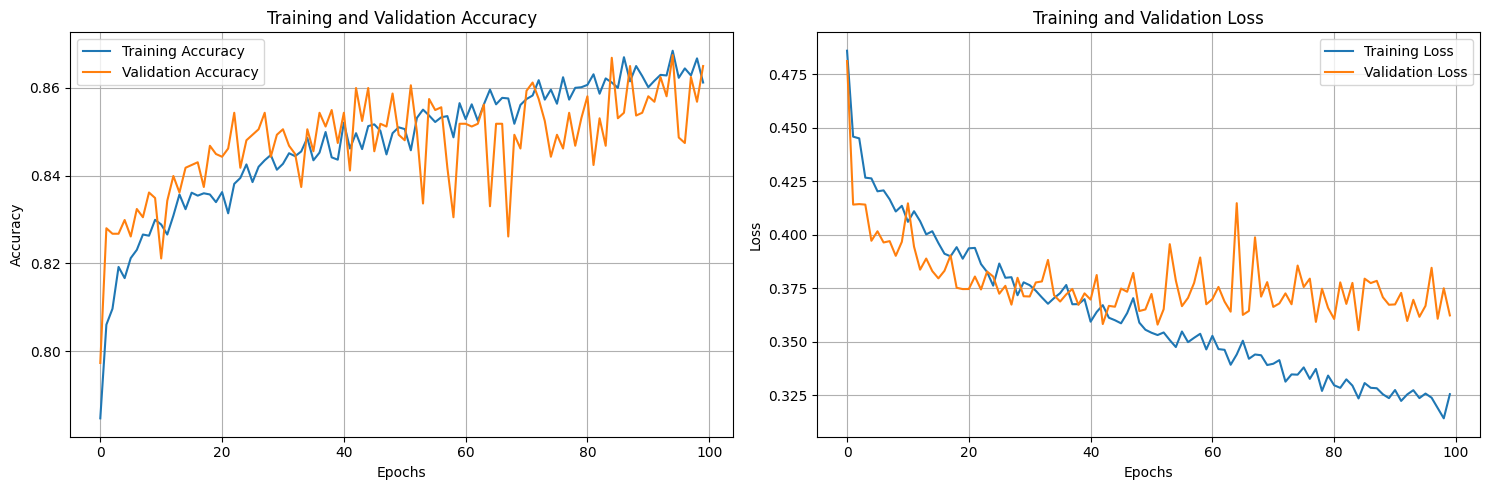

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step
              precision    recall  f1-score   support

         all       0.68      0.74      0.71      1091
         hem       0.31      0.25      0.27       509

    accuracy                           0.58      1600
   macro avg       0.49      0.49      0.49      1600
weighted avg       0.56      0.58      0.57      1600



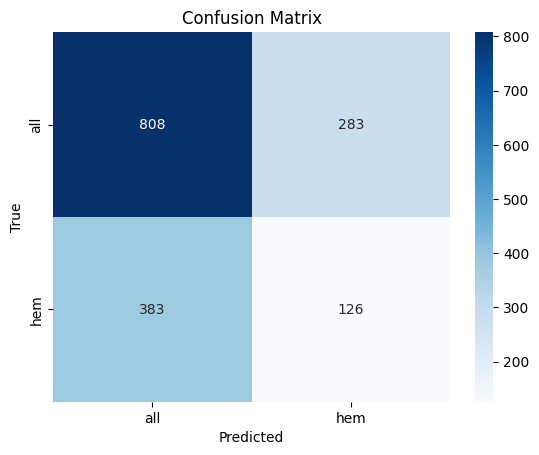

In [ ]:
#EfficientNet B0
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

# Paths to your data
base_dir = '/content/leukemia_data'  # Update this path as necessary
train_dir = os.path.join(base_dir, 'C-NMC_Leukemia/training_data/')
test_csv = os.path.join(base_dir, 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')
test_imgs = os.path.join(base_dir, 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/')

# Define paths and labels
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for fold_ in filelist:
            foldpath_ = os.path.join(foldpath, fold_)
            filelist_ = os.listdir(foldpath_)
            for file_ in filelist_:
                fpath = os.path.join(foldpath_, file_)
                filepaths.append(fpath)
                labels.append(fold_)
    return filepaths, labels

# Create DataFrame
def create_df(data_dir):
    filepaths, labels = define_paths(data_dir)
    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
    return train_df, valid_df, test_df

# Create data generators
def create_data_generators(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)

    train_gen = ImageDataGenerator(horizontal_flip=True).flow_from_dataframe(train_df, x_col='filepaths',
                                                                           y_col='labels', target_size=img_size,
                                                                           class_mode='categorical', batch_size=batch_size)

    valid_gen = ImageDataGenerator().flow_from_dataframe(valid_df, x_col='filepaths',
                                                          y_col='labels', target_size=img_size,
                                                          class_mode='categorical', batch_size=batch_size)

    test_gen = ImageDataGenerator().flow_from_dataframe(test_df, x_col='filepaths',
                                                         y_col='labels', target_size=img_size,
                                                         class_mode='categorical', batch_size=batch_size)

    return train_gen, valid_gen, test_gen

# Define and compile the model with EfficientNetB0
def create_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')  # Adjust based on your number of classes
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the model
def train_model(model, train_gen, valid_gen, epochs):
    history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs)
    return history

# Plotting functions
def plot_metrics(history):
    # Plotting training and validation accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Evaluate model and plot confusion matrix
def evaluate_model(model, test_gen):
    test_gen.reset()
    y_pred = model.predict(test_gen)
    pred_labels = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes

    # Print classification report
    print(classification_report(y_true, pred_labels, target_names=test_gen.class_indices.keys()))

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Main execution
data_dir = '/content/leukemia_data/C-NMC_Leukemia/training_data'  # Update this path
train_df, valid_df, test_df = create_df(data_dir)
batch_size = 32  # Adjust based on your GPU memory
train_gen, valid_gen, test_gen = create_data_generators(train_df, valid_df, test_df, batch_size)

# Create and train the EfficientNetB0 model
model = create_model()
epochs = 100  # Set the desired number of epochs here
history = train_model(model, train_gen, valid_gen, epochs)

# Plot metrics and evaluate model
plot_metrics(history)
evaluate_model(model, test_gen)


Found 7462 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


234/234 ━━━━━━━━━━━━━━━━━━━━ 70s 236ms/step - accuracy: 0.7546 - loss: 0.5934 - val_accuracy: 0.7924 - val_loss: 0.4692
Epoch 2/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.8143 - loss: 0.4369 - val_accuracy: 0.8230 - val_loss: 0.4380
Epoch 3/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.8139 - loss: 0.4348 - val_accuracy: 0.8299 - val_loss: 0.4269
Epoch 4/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.8179 - loss: 0.4245 - val_accuracy: 0.8218 - val_loss: 0.4181
Epoch 5/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.8215 - loss: 0.4142 - val_accuracy: 0.8280 - val_loss: 0.4072
Epoch 6/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.8168 - loss: 0.4272 - val_accuracy: 0.8293 - val_loss: 0.4033
Epoch 7/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.8333 - loss: 0.4015 - val_accuracy: 0.8249 - val_loss: 0.4236
Epoch 8/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.8212 - loss: 0.419

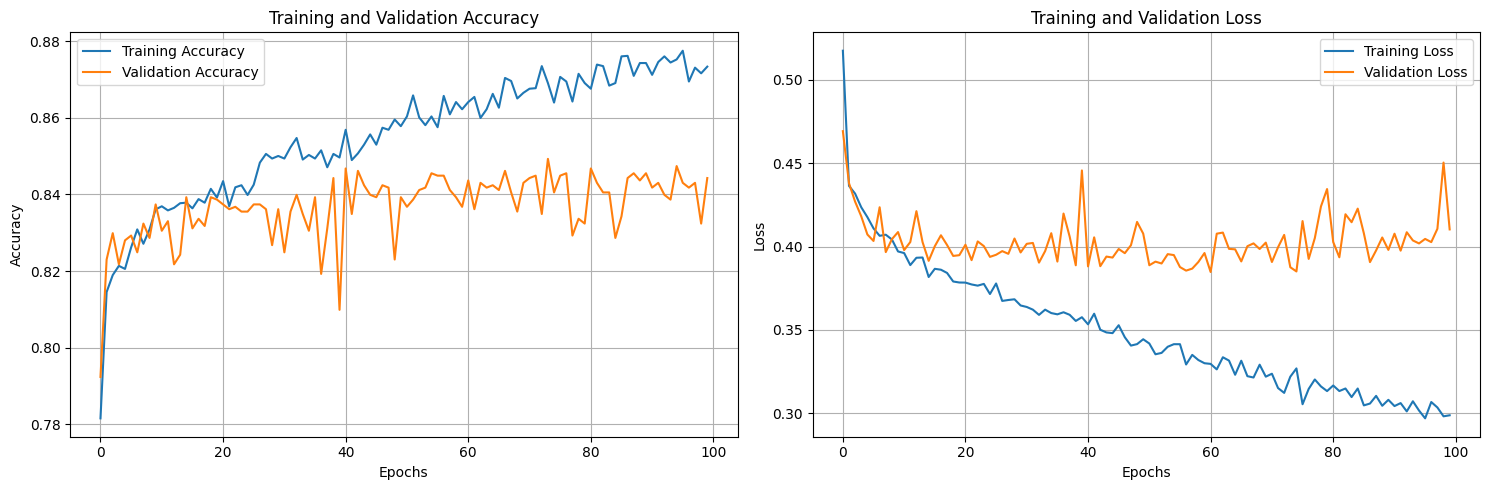

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step
              precision    recall  f1-score   support

         all       0.68      0.74      0.71      1091
         hem       0.30      0.24      0.27       509

    accuracy                           0.58      1600
   macro avg       0.49      0.49      0.49      1600
weighted avg       0.56      0.58      0.57      1600



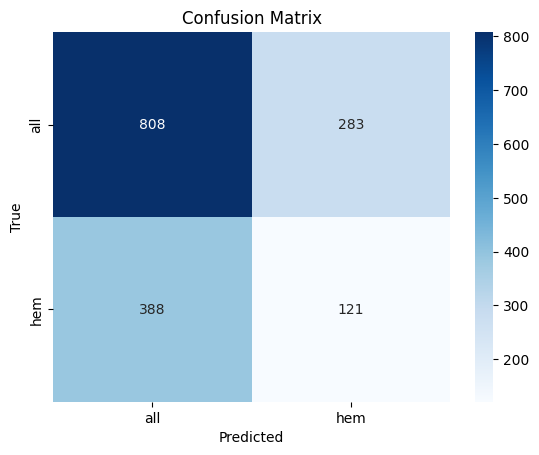

In [ ]:
#VGG19-remove
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models

# Paths to your data
base_dir = '/content/leukemia_data'  # Update this path as necessary
train_dir = os.path.join(base_dir, 'C-NMC_Leukemia/training_data/')
test_csv = os.path.join(base_dir, 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')
test_imgs = os.path.join(base_dir, 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/')

# Define paths and labels
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for fold_ in filelist:
            foldpath_ = os.path.join(foldpath, fold_)
            filelist_ = os.listdir(foldpath_)
            for file_ in filelist_:
                fpath = os.path.join(foldpath_, file_)
                filepaths.append(fpath)
                labels.append(fold_)
    return filepaths, labels

# Create DataFrame
def create_df(data_dir):
    filepaths, labels = define_paths(data_dir)
    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
    return train_df, valid_df, test_df

# Create data generators
def create_data_generators(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)  # VGG19 input size

    train_gen = ImageDataGenerator(horizontal_flip=True).flow_from_dataframe(train_df, x_col='filepaths',
                                                                           y_col='labels', target_size=img_size,
                                                                           class_mode='categorical', batch_size=batch_size)

    valid_gen = ImageDataGenerator().flow_from_dataframe(valid_df, x_col='filepaths',
                                                          y_col='labels', target_size=img_size,
                                                          class_mode='categorical', batch_size=batch_size)

    test_gen = ImageDataGenerator().flow_from_dataframe(test_df, x_col='filepaths',
                                                         y_col='labels', target_size=img_size,
                                                         class_mode='categorical', batch_size=batch_size)

    return train_gen, valid_gen, test_gen

# Define and compile the model with VGG19
def create_model():
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')  # Adjust based on your number of classes
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the model
def train_model(model, train_gen, valid_gen, epochs):
    history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs)
    return history

# Plotting functions
def plot_metrics(history):
    # Plotting training and validation accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Evaluate model and plot confusion matrix
def evaluate_model(model, test_gen):
    test_gen.reset()
    y_pred = model.predict(test_gen)
    pred_labels = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes

    # Print classification report
    print(classification_report(y_true, pred_labels, target_names=test_gen.class_indices.keys()))

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Main execution
data_dir = '/content/leukemia_data/C-NMC_Leukemia/training_data'  # Update this path
train_df, valid_df, test_df = create_df(data_dir)
batch_size = 32  # Adjust based on your GPU memory
train_gen, valid_gen, test_gen = create_data_generators(train_df, valid_df, test_df, batch_size)

# Create and train the VGG19 model
model = create_model()
epochs = 100  # Set the desired number of epochs here
history = train_model(model, train_gen, valid_gen, epochs)

# Plot metrics and evaluate model
plot_metrics(history)
evaluate_model(model, test_gen)


Found 7462 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


234/234 ━━━━━━━━━━━━━━━━━━━━ 78s 249ms/step - accuracy: 0.7258 - loss: 1.1649 - val_accuracy: 0.7855 - val_loss: 0.4952
Epoch 2/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - accuracy: 0.7946 - loss: 0.4792 - val_accuracy: 0.7974 - val_loss: 0.4704
Epoch 3/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - accuracy: 0.7903 - loss: 0.4837 - val_accuracy: 0.7974 - val_loss: 0.4657
Epoch 4/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - accuracy: 0.7772 - loss: 0.5108 - val_accuracy: 0.7936 - val_loss: 0.4699
Epoch 5/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - accuracy: 0.7934 - loss: 0.4916 - val_accuracy: 0.7999 - val_loss: 0.4574
Epoch 6/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - accuracy: 0.7939 - loss: 0.4924 - val_accuracy: 0.8118 - val_loss: 0.4526
Epoch 7/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - accuracy: 0.7998 - loss: 0.4813 - val_accuracy: 0.7861 - val_loss: 0.4790
Epoch 8/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - accuracy: 0.7998 - loss: 0.473

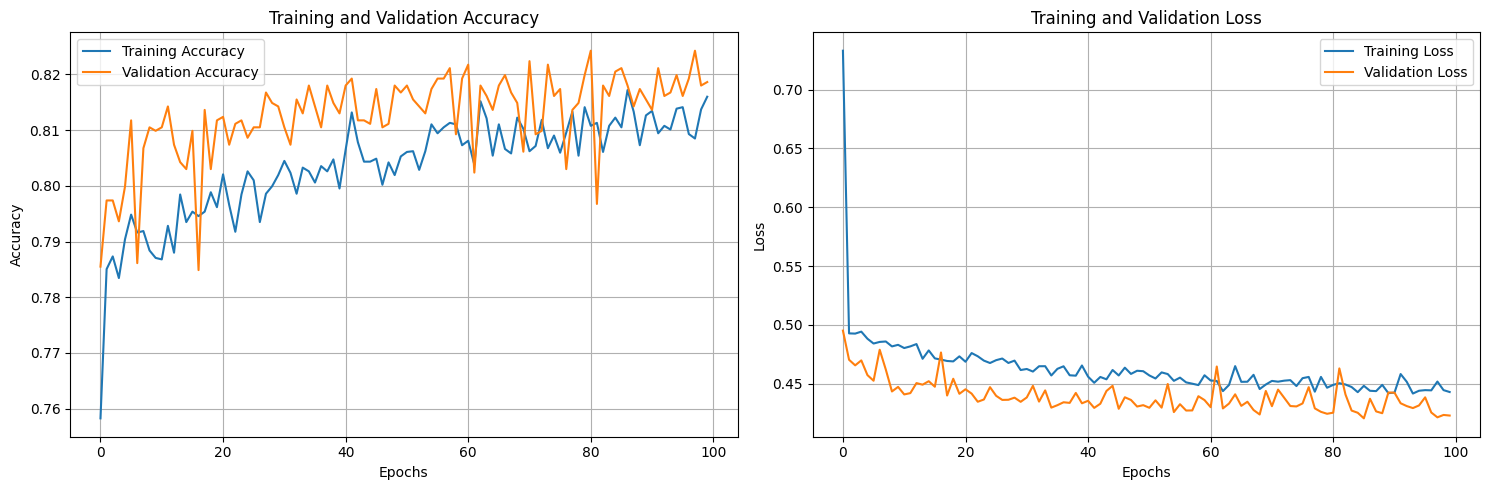

50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step
              precision    recall  f1-score   support

         all       0.67      0.77      0.72      1091
         hem       0.29      0.21      0.24       509

    accuracy                           0.59      1600
   macro avg       0.48      0.49      0.48      1600
weighted avg       0.55      0.59      0.57      1600



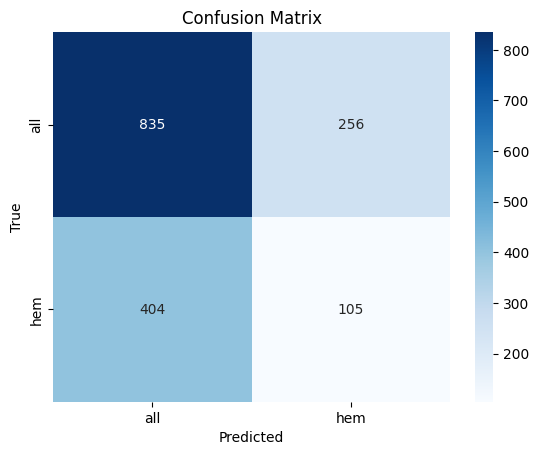

In [ ]:
#Inceptionv3
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models

# Paths to your data
base_dir = '/content/leukemia_data'  # Update this path as necessary
train_dir = os.path.join(base_dir, 'C-NMC_Leukemia/training_data/')
test_csv = os.path.join(base_dir, 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')
test_imgs = os.path.join(base_dir, 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/')

# Define paths and labels
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for fold_ in filelist:
            foldpath_ = os.path.join(foldpath, fold_)
            filelist_ = os.listdir(foldpath_)
            for file_ in filelist_:
                fpath = os.path.join(foldpath_, file_)
                filepaths.append(fpath)
                labels.append(fold_)
    return filepaths, labels

# Create DataFrame
def create_df(data_dir):
    filepaths, labels = define_paths(data_dir)
    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
    return train_df, valid_df, test_df

# Create data generators
def create_data_generators(train_df, valid_df, test_df, batch_size):
    img_size = (299, 299)  # InceptionV3 input size

    train_gen = ImageDataGenerator(horizontal_flip=True).flow_from_dataframe(train_df, x_col='filepaths',
                                                                           y_col='labels', target_size=img_size,
                                                                           class_mode='categorical', batch_size=batch_size)

    valid_gen = ImageDataGenerator().flow_from_dataframe(valid_df, x_col='filepaths',
                                                          y_col='labels', target_size=img_size,
                                                          class_mode='categorical', batch_size=batch_size)

    test_gen = ImageDataGenerator().flow_from_dataframe(test_df, x_col='filepaths',
                                                         y_col='labels', target_size=img_size,
                                                         class_mode='categorical', batch_size=batch_size)

    return train_gen, valid_gen, test_gen

# Define and compile the model with InceptionV3
def create_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')  # Adjust based on your number of classes
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the model
def train_model(model, train_gen, valid_gen, epochs):
    history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs)
    return history

# Plotting functions
def plot_metrics(history):
    # Plotting training and validation accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Evaluate model and plot confusion matrix
def evaluate_model(model, test_gen):
    test_gen.reset()
    y_pred = model.predict(test_gen)
    pred_labels = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes

    # Print classification report
    print(classification_report(y_true, pred_labels, target_names=test_gen.class_indices.keys()))

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Main execution
data_dir = '/content/leukemia_data/C-NMC_Leukemia/training_data'  # Update this path
train_df, valid_df, test_df = create_df(data_dir)
batch_size = 32  # Adjust based on your GPU memory
train_gen, valid_gen, test_gen = create_data_generators(train_df, valid_df, test_df, batch_size)

# Create and train the InceptionV3 model
model = create_model()
epochs = 100  # Set the desired number of epochs here
history = train_model(model, train_gen, valid_gen, epochs)

# Plot metrics and evaluate model
plot_metrics(history)
evaluate_model(model, test_gen)



Found 7462 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


234/234 ━━━━━━━━━━━━━━━━━━━━ 160s 357ms/step - accuracy: 0.6737 - loss: 0.7656 - val_accuracy: 0.7792 - val_loss: 0.6311
Epoch 2/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 33s 138ms/step - accuracy: 0.7562 - loss: 0.5943 - val_accuracy: 0.8305 - val_loss: 0.4368
Epoch 3/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - accuracy: 0.8018 - loss: 0.5032 - val_accuracy: 0.8612 - val_loss: 0.3624
Epoch 4/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - accuracy: 0.8197 - loss: 0.4545 - val_accuracy: 0.8574 - val_loss: 0.3796
Epoch 5/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - accuracy: 0.8264 - loss: 0.4259 - val_accuracy: 0.8668 - val_loss: 0.3265
Epoch 6/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - accuracy: 0.8343 - loss: 0.4192 - val_accuracy: 0.8768 - val_loss: 0.3275
Epoch 7/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - accuracy: 0.8464 - loss: 0.3930 - val_accuracy: 0.8762 - val_loss: 0.3283
Epoch 8/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - accuracy: 0.8620 - loss: 0.36

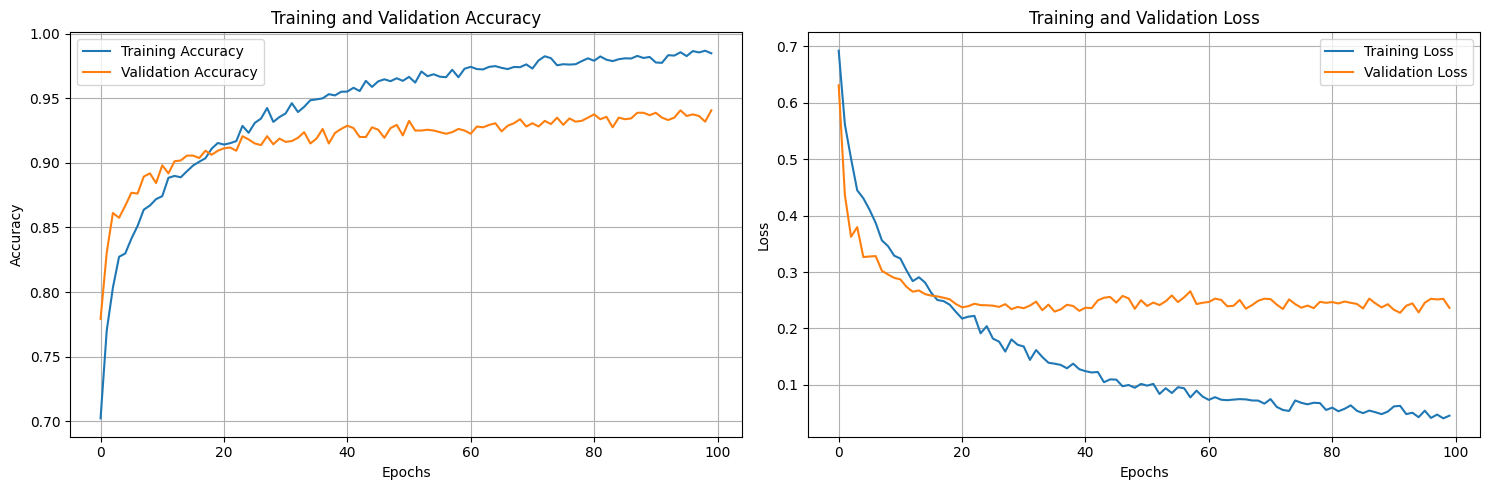

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step
              precision    recall  f1-score   support

         all       0.68      0.69      0.68      1091
         hem       0.30      0.29      0.30       509

    accuracy                           0.56      1600
   macro avg       0.49      0.49      0.49      1600
weighted avg       0.56      0.56      0.56      1600



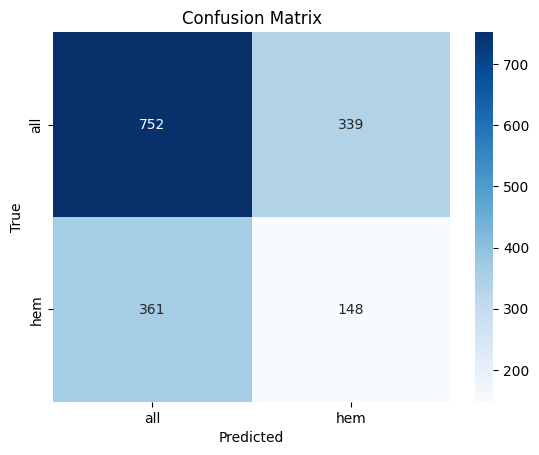

In [ ]:
#Iproved efficientnetB0 - proposed model
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.layers import MultiHeadAttention, LeakyReLU, BatchNormalization

# Paths to your data
base_dir = '/content/leukemia_data'  # Update this path as necessary
train_dir = os.path.join(base_dir, 'C-NMC_Leukemia/training_data/')
test_csv = os.path.join(base_dir, 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')
test_imgs = os.path.join(base_dir, 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/')

# Define paths and labels
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for fold_ in filelist:
            foldpath_ = os.path.join(foldpath, fold_)
            filelist_ = os.listdir(foldpath_)
            for file_ in filelist_:
                fpath = os.path.join(foldpath_, file_)
                filepaths.append(fpath)
                labels.append(fold_)
    return filepaths, labels

# Create DataFrame
def create_df(data_dir):
    filepaths, labels = define_paths(data_dir)
    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
    return train_df, valid_df, test_df

# Create data generators
def create_data_generators(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)

    train_gen = ImageDataGenerator(horizontal_flip=True).flow_from_dataframe(train_df, x_col='filepaths',
                                                                           y_col='labels', target_size=img_size,
                                                                           class_mode='categorical', batch_size=batch_size)

    valid_gen = ImageDataGenerator().flow_from_dataframe(valid_df, x_col='filepaths',
                                                          y_col='labels', target_size=img_size,
                                                          class_mode='categorical', batch_size=batch_size)

    test_gen = ImageDataGenerator().flow_from_dataframe(test_df, x_col='filepaths',
                                                         y_col='labels', target_size=img_size,
                                                         class_mode='categorical', batch_size=batch_size)

    return train_gen, valid_gen, test_gen

# Define and compile the modified model with EfficientNetB0 using functional API
def create_improved_model():
    input_tensor = tf.keras.Input(shape=(224, 224, 3))

    # EfficientNetB0 base model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # Unfreeze some layers for fine-tuning
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    # Reshape for MultiHeadAttention
    x = layers.Reshape((1, 1280))(x)  # Shape to (batch_size, 1, 1280) for attention
    attention_output = MultiHeadAttention(num_heads=4, key_dim=1280, dropout=0.3)(x, x)  # Self-attention
    x = layers.Reshape((1280,))(attention_output)  # Reshape back

    # Fully connected layers with Batch Normalization and Dropout
    x = layers.Dense(256)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Output layer
    output = layers.Dense(2, activation='softmax')(x)

    # Compile the model
    model = tf.keras.Model(inputs=input_tensor, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train the model
def train_model(model, train_gen, valid_gen, epochs):
    history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs)
    return history

# Plotting functions
def plot_metrics(history):
    # Plotting training and validation accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Evaluate model and plot confusion matrix
def evaluate_model(model, test_gen):
    test_gen.reset()
    y_pred = model.predict(test_gen)
    pred_labels = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes

    # Print classification report
    print(classification_report(y_true, pred_labels, target_names=test_gen.class_indices.keys()))

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Main execution
data_dir = '/content/leukemia_data/C-NMC_Leukemia/training_data'  # Update this path
train_df, valid_df, test_df = create_df(data_dir)
batch_size = 32  # Adjust based on your GPU memory
train_gen, valid_gen, test_gen = create_data_generators(train_df, valid_df, test_df, batch_size)

# Create and train the EfficientNetB0 model
model = create_improved_model()
epochs = 100  # Set the desired number of epochs here
history = train_model(model, train_gen, valid_gen, epochs)

# Plot metrics and evaluate model
plot_metrics(history)
evaluate_model(model, test_gen)
